In [1]:
import sys
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')
import ast
import json
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
import json
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
import keras.backend as K
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Import data
df = pd.read_csv('../data/output/tripadvisor/dataset_sequence.csv', sep = ';')[['review_rating', 'review_text_token_flag_index']]
df['review_text_token_flag_index_list'] = df['review_text_token_flag_index'].apply(lambda x: ast.literal_eval(x))

# Split data in train, test and validation

Prima di procede con lo split verifico se il dataset è bilanciato o no rispetto le classi.

In [3]:
df['review_rating_01'] = df['review_rating'].apply(lambda x: 1 if x==1 else 0)
df['review_rating_01'].value_counts()

1    69157
0     6632
Name: review_rating_01, dtype: int64

Si osserva che il dataset è fortemente sbilanciato, il che potrebbe implicare una'ottima capacità di individuare review positive e una scarsa abilità ad individuare le negative. Per affrontare tale, ricorrente, problema, si prendono in considerazione quattro diverse strategie:

1. Down-sample Majority Class: dove al contrario si scelgono randomicamente without replacement esempi positivi da rimuovere per pareggiare la classe in minoranza
2. Up-sample Minority Class: dove randomicamente without replacement si pescano sample negativi fino a pareggiare le due classi
3. Rebalance che prevede di allenare il modello su più dataset bilanciati. In particolare, in questo caso, si creano 10 dataset di 6632 unità negative e altrettante 6632 positive scelte in modo random, così che almeno tutti i campioni positivi siano visti dai modelli. Si procede quindi con *voting procedure* rispetto alle predizioni dei 10 modelli per predire la classe definitiva.
4. Rebalancing in fase di K-fold


__Prima di procedere con le operazioni creiamo il validation set composto dal 10% dei nostri sample (metà negativo e metà positivo). __



In [2]:
from train_test import *

In [5]:
df_validation, df_majority, df_minority = create_balanced_validation(df, 1, percentage = 5)


Procediamo con il Down-sample della Majority Class.


* Separiamo i sample delle due classi in due df
* Facciamo samplin senza reimissione così da ottenere un numero si esempi pari al numero di sample della minority class.
* Combiniamo i due dataset.

In [3]:
from balancing import *

In [7]:
df_downsampled = downsample_majority_class(df_majority, df_minority)

1    4738
0    4738
Name: review_rating_01, dtype: int64


## Define X and Y for the training step

In [8]:
x_train_pad, y_train, x_validation_pad, y_validation, max_len_seq, max_idx = train_validation_tripadvisor(df_downsampled, df_validation)

max len seq 937
max id 60841


## Split in train and test

We split in train and set using the Stratified Shuffle Split that draws sample s.t. the proportin of the classes holds both in the train and test.

In [9]:
split_train_test = StratifiedShuffleSplit(1,test_size=0.2, random_state=123456)

for train, test in split_train_test.split(x_train_pad, y_train):
    x_train_pad_split, y_train_pad_split = x_train_pad[train], y_train[train]
    x_val_pad_split, y_val_pad_split = x_train_pad[test], y_train[test]

## Build the model

In [4]:
from evaluation_metrics import *

In [11]:
def build_model():
    
    model = Sequential()
    model.add(Embedding(input_dim=max_idx+1, output_dim=50, input_length=max_len_seq))
    model.add(Conv1D(filters=8, kernel_size=10, padding='same', activation='relu', strides=2))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=8, kernel_size=10, padding='same', activation='relu', strides=2))
    model.add(GlobalMaxPool1D())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', precision, recall])
    
    return model

In [12]:
model = build_model()
model.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 937, 50)           3042100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 469, 8)            4008      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 234, 8)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 117, 8)            648       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                450       
___________________________________________________________

## Prova

1. buono con filters=8, window = 10, stride = 2

In [13]:
history = model.fit(x_train_pad_split, y_train_pad_split, validation_data=(x_val_pad_split, y_val_pad_split),
                    batch_size=200, validation_split=0.2, epochs=10)

Train on 7580 samples, validate on 1896 samples
Epoch 1/10
7580/7580 [==============================] - 19s 2ms/step - loss: 0.6892 - acc: 0.5402 - precision: 0.6442 - recall: 0.1925 - val_loss: 0.6781 - val_acc: 0.6340 - val_precision: 0.7881 - val_recall: 0.3678
Epoch 2/10
7580/7580 [==============================] - 15s 2ms/step - loss: 0.6078 - acc: 0.7278 - precision: 0.8263 - recall: 0.5787 - val_loss: 0.4782 - val_acc: 0.8228 - val_precision: 0.8259 - val_recall: 0.8195
Epoch 3/10
7580/7580 [==============================] - 14s 2ms/step - loss: 0.3306 - acc: 0.8817 - precision: 0.8756 - recall: 0.8899 - val_loss: 0.2449 - val_acc: 0.9051 - val_precision: 0.8924 - val_recall: 0.9221
Epoch 4/10
7580/7580 [==============================] - 14s 2ms/step - loss: 0.1579 - acc: 0.9476 - precision: 0.9390 - recall: 0.9570 - val_loss: 0.2179 - val_acc: 0.9124 - val_precision: 0.9165 - val_recall: 0.9072
Epoch 5/10
7580/7580 [==============================] - 14s 2ms/step - loss: 0.0877 

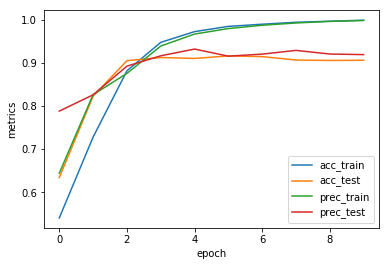

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.ylabel('metrics')
plt.xlabel('epoch')
plt.legend(['acc_train', 'acc_test', 'prec_train', 'prec_test'], loc='lower right')

## Evaluate the model on the validation set

* We compute the class predictions
* We see the evaluation using precision, recall, f1 and accuracy

In [15]:
prediction = model.predict_classes(x_validation_pad)

In [16]:
evaluate_model(model, x_validation_pad, y_validation)

Modelevaluation: 
Accuracy: 0.9200105596620908 
Precision: 0.9076029567053854 
Recall: 0.9306984298863021 
F1: 0.9190056134723336


These metrics are computed on a validation set that has been randomly created (explanation throughout the pipeline). Thus, if the notebook will be executed again those can vary.